# 509 Final Project

## Rsolve dependencies

In [1]:
! pip install newsapi-python

## Globally import libraries

In [25]:
#! pip install pyLDavis

import pyLDAvis

pyLDAvis.enable_notebook()
from tqdm.auto import tqdm

import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import numpy as np
import pandas as pd
import pymysql as mysql
import matplotlib.pyplot as plt
import os
import shutil
import re
import logging
import time
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
from collections import defaultdict, Counter
import random
import requests
from bs4 import BeautifulSoup
import datetime
import json
from wordcloud import WordCloud 



import sqlite3
import nltk
from string import punctuation
from nltk.corpus import stopwords
import re
import emoji
from nltk.metrics import ConfusionMatrix
import itertools
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
#import mysql.connector

# Set pandas global options
pd.options.display.max_rows = 17

## Functions:

### Data pre-processing:

In [4]:
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}


# Stopwords - added the 'nan' to this to remove nulls:
# next step could be to add pronouns like she/her, he/him, etc.

sw = stopwords.words("english")
sw = sw + ['nan']
sw = sw + ['said'] + ['news'] + ['us']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

def remove_stop(tokens) :
    # modify this function to remove stopwords

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    
def remove_url(text):
    return(re.sub(r'http\S+', '', text))

def remove_messy(text): # remove words that give away the source
    text1=re.sub(r'cnn', '', text)
    text2=re.sub(r'fox', '', text1)
    text3=re.sub(r' — ', '', text2)
    text4=re.sub(r'breatbart', '', text3)
    return(re.sub(r'\\n', '', text4))

# two pipelines to either tokenize or simply remove punctuation
# and lowercase as we will need to extract feature words:

full_pipeline = [str.lower, remove_url, remove_messy, remove_punctuation, tokenize, remove_stop]
first_pipeline = [str.lower, remove_url, remove_messy, remove_punctuation]


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

### Feature extraction Function:

In [5]:
def conv_features(text,fw) :
     feature_set=dict()
     for word in text.split():
          if word in fw:
               feature_set[word]=True
     return(feature_set)

### EDA functions:

Get Patterns, Counts, WordCloud:

In [6]:
def get_patterns(text_analyze, num_words, T):
    if(len(text_analyze)==0):
        raise ValueError("Can't work with empty text object")
    total_tokens = 1
    unique_tokens = 0
    avg_token_len = 0.0
    lexical_diversityP = 0.0
    top_words = []

    # Only applying the token_normal, which takes only alphanumeric values
    # to twitter data:
    if T ==1:
        text_analyze=token_normal(text_analyze)

    total_tokens = len(text_analyze)
    unique_tokens = len(set(text_analyze))
    lexical_diversityP = unique_tokens/total_tokens
    avg_token_len = np.mean([len(ta) for ta in text_analyze])

    top_words_1 = collections.Counter(text_analyze)
    top_words = top_words_1.most_common(num_words)

    results={'tokens': total_tokens,
             'unique_tokens': unique_tokens,
             'avg_token_length': avg_token_len,
             'lexical_diversity': lexical_diversityP,
             'top_words': top_words}
    return(results)

In [17]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
# Here, we only apply splitting to the lyrics data due to the difference
# in dataframe/data ingestion between twitter and lycis data:
    
#def count_words(df, column='tokens', preprocess=None, min_freq=2, split=0):
def count_words(x, preprocess=None, min_freq=2, split=0):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    #counter = collections.Counter()
    #top_words_1 = collections.Counter(text_analyze)
    #top_words = top_words_1.most_common(num_words)
    if split == 0:
        counter = collections.Counter(x)
    else: 
        counter = collections.Counter(x.split())

    #df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [26]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [2]:
today = datetime.date.today()
print(today)
print(type(today))

2023-06-03
<class 'datetime.date'>


## Connect to NewsAPI client

In [3]:
from newsapi import NewsApiClient

api_key = os.environ['NewsAPIKey']

# Init
newsapi = NewsApiClient(api_key=api_key)

## Pull article info from API

### /v2/top-headlines/sources
sources = newsapi.get_sources()
print(sources)

In [6]:
def news_api_urls(q=None,
                  s=None,
                  d_from='2023-05-01',
                  d_to='2023-05-31',
                  api_lst=[]):
    all_articles = newsapi.get_everything(q=q,
                                          sources=s,
                                          from_param=d_from,
                                          to=d_to,
                                          language='en',
                                          sort_by='relevancy',
                                          page=1)

    print(type(all_articles))
    print(all_articles)
    #print('Article list: ', all_articles['articles'])
    for article in all_articles['articles']:
        print('Source ID:', article['source']['id'])
        print('Source name:', article['source']['name'])
        print('Author:', article['author'])
        print('Title:', article['title'])
        print('URL:', article['url'])
        print('Publish date:', article['publishedAt'])
        print('Article text:', article['content'], '\n')

    # Create a list of tuples from the dictionary data
    source_data01 = [(a['source']['name'],
                      a['author'],
                      a['title'],
                      a['url'],
                      a['publishedAt'],
                      a['content'])
                     for a in all_articles['articles']]

    api_lst.extend(source_data01)
    #print(api_lst)
    print(len(api_lst))

## Connect to API to access URLs

### Set API filter parameters

In [401]:
# Citation comes from Allsides Media Bias Chart

source_lst = ['the-washington-post','cnn','fox-news','breitbart-news']


#date_lst = ['2023-05-31', '2023-05-20']

#date_lst = ['2023-05-30']

# Comes from academci text (fill in citation from DF)
#q_word_lst = ['gender OR male OR female OR transgender', 'security AND (social OR national)',
#              'justice OR surveillance', 'healthcare OR "health care"',
#              '(political AND (bias OR party)) OR republican OR democrat OR election', '(policy AND (drug OR "affirmative action")) OR regulate OR regulation']


date_lst = ['2023-05-18', '2023-05-19', '2023-05-21', '2023-05-22', '2023-05-23'] 

#             '2023-05-24', '2023-05-25',
#            '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-31']

q_word_lst = ['justice OR surveillance', 'healthcare OR "health care"',
              '(political AND (bias OR party)) OR republican OR democrat OR election',
              'security AND (social OR national)', '(policy AND (drug OR "affirmative action")) OR regulate OR regulation']

#q_word_lst = ['healthcare OR "health care"',
#              '(political AND (bias OR party)) OR republican OR democrat OR election',
#              'security AND (social OR national)']


### Access API

In [402]:
api_record_lst01 = []
for s in source_lst:
    print(f'Source: {s}')
    for d in date_lst:
        print(f'Date: {d}')
        for q in q_word_lst:
            print(f'Query word: {q}')
            time.sleep(5 + 11 * random.random())
            news_api_urls(q=q,
                          s=s,
                          d_from=d,
                          d_to=d,
                          api_lst=api_record_lst01)
            print(s, d, q)
    time.sleep(10 + 13 * random.random())

print(api_record_lst01)
print(len(api_record_lst01))

Source: the-washington-post
Date: 2023-05-18
Query word: justice OR surveillance
<class 'dict'>
{'status': 'ok', 'totalResults': 6, 'articles': [{'source': {'id': 'the-washington-post', 'name': 'The Washington Post'}, 'author': 'Ellen Nakashima', 'title': 'GOP memo on surveillance ‘abuse’ seeks to discredit the Trump-Russia dossier', 'description': 'Republicans say the document looks bad for the FBI. Democrats say it’s a ploy to cripple investigations of the 2016 election.', 'url': 'https://www.washingtonpost.com/powerpost/gop-memo-on-surveillance-abuse-seeks-to-discredit-the-trump-russia-dossier/2018/01/19/7b4babbc-fd3f-11e7-a46b-a3614530bd87_story.html', 'urlToImage': 'https://www.washingtonpost.com/resizer/2CjPNwqvXHPS_2RpuRTKY-p3eVo=/1484x0/www.washingtonpost.com/pb/resources/img/twp-social-share.png', 'publishedAt': '2023-05-18T14:00:02Z', 'content': 'Comment on this story\r\nComment\r\nA document described by House Republicans as a top-secret memo about surveillance abuse contain

Article data saved into dataframe:

In [403]:
api_record_df2 = pd.DataFrame (list (api_record_lst01),
                                   columns = ['Source','Author','Title','URL','date','content'])

In [396]:
api_record_df = pd.DataFrame (list (api_record_lst01),
                                   columns = ['Source','Author','Title','URL','date','content'])

In [405]:
api_record_df_final = pd.concat([api_record_df2, api_record_df])


In [406]:
api_record_df_final.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31.csv", sep=',')


In [404]:
api_record_df.to_csv("News_API_FOX_CNN_Breitbert_May20_May31.csv", sep=',')
api_record_df2.to_csv("News_API_FOX_CNN_Breitbert_May1819_May2123.csv", sep=',')

In [415]:
api_record_df_filtered = api_record_df[api_record_df.Source != 'The Washington Post']

In [4]:
api_data_df3=pd.read_csv('News_API_FOX_CNN_Breitbert_May18_23_May31_2.csv')


In [5]:
api_record_df_final3 = api_data_df3[api_data_df3.Source != 'The Washington Post']

In [6]:
api_record_df_final3.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31_3.csv", sep=',')


In [7]:
api_record_df_final3.shape

(1302, 7)

In [417]:
api_record_df_filtered.shape

(333, 6)

In [418]:
api_record_df2.shape

(1113, 6)

In [419]:
api_record_df_final2 = pd.concat([api_record_df2, api_record_df_filtered])


In [420]:
api_record_df_final2.shape

(1446, 6)

In [421]:
api_record_df_final2.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31_2.csv", sep=',')


In [12]:
api_data_df_final3=pd.read_csv('News_API_FOX_CNN_Breitbert_May18_23_May31_2.csv')


In [13]:
api_record_df_final3.head()

,Unnamed: 0,Source,Author,Title,URL,date,content
144,144,CNN,Joan Biskupic,Behind the scenes in 2000 when Supreme Court l...,https://www.cnn.com/2023/05/18/politics/gay-ri...,2023-05-18T09:00:43Z,As he began writing an angry dissent in a gay ...
145,145,CNN,Alisha Ebrahimji,A liquor store clerk was indicted after she al...,https://www.cnn.com/2023/05/18/us/massachusett...,2023-05-18T19:32:20Z,"A liquor store clerk schemed, stole and tried ..."
146,146,CNN,Ariane de Vogue,Supreme Court rules against Andy Warhol in cop...,https://www.cnn.com/2023/05/18/politics/suprem...,2023-05-18T14:18:01Z,The Supreme Court ruled Thursday that the late...
147,147,CNN,Brian Fung,Supreme Court shields Twitter from liability f...,https://www.cnn.com/2023/05/18/politics/suprem...,2023-05-18T14:30:58Z,Twitter will not have to face accusations it a...
148,148,CNN,Alayna Treene,National Archives officials testify that every...,https://www.cnn.com/2023/05/17/politics/classi...,2023-05-18T01:54:14Z,Every administration since President Ronald Re...


### Extract Article through HTML scrape

FOX, CNN, Breitbert:

In [21]:
slct_tbl_full_df02 = api_record_df_final3.copy()
#slct_tbl_full_df02 = slct_tbl_full_df01.sort_values(by=['source_name'])
#slct_tbl_full_df02 = slct_tbl_full_df02.reset_index()

#print(f'DF instances: {len(slct_tbl_full_df02)}')

slct_tbl_full_df02['article_parsed'] = ''

total_urls = len(slct_tbl_full_df02)

# Start timer
start_time = datetime.date.today()


#for i, row in enumerate(slct_tbl_full_df02.itertuples(), 1):
for i, row in enumerate(slct_tbl_full_df02.itertuples(), 1):
    print(row[5])
    article=[]
    #url = slct_tbl_full_df02.at[i,'URL']
    url=row[5]
    response = requests.get(url)
    time.sleep(5 + 10*random.random())
    #print(f'Enumeration #: {i}')
    #print(row[7])
    soup = BeautifulSoup(response.text, 'html.parser')

    try:
        script_tag = soup.find('script', {'type': 'application/ld+json'})
        if script_tag == None:
            print('\nJSON Object == None: Index:', i-1, '; source:',
                  row[2],
                  '; URL:', row[5])
        else:
            article_json = json.loads(script_tag.string)
            article_content = article_json['articleBody']
            slct_tbl_full_df02.at[row.Index, 'article_parsed'] = article_content

    except KeyError:
        print('\nMissing JSON key: Index:', i-1, '; source:',
              row[2],
              '; URL:', row[5])
        article_body = soup.find('div', class_='article__content-container')

        if article_body is None: #forfoxandbreitbert(sometimes)
            print('Class != article__content-container')
            article_body = soup.find('p', class_="speakable")
            if article_body is None: #breitbert(most)
                print('Class != speakable')
                article_body = soup.find('div', class_='entry-content')
                if article_body is None: #WashPost
                    print('Class != entry-content')
                    article_body = soup.find('div',class_='article-body')

        if article_body is not None:
            article_text = article_body.get_text()
            slct_tbl_full_df02.at[row.Index, 'article_parsed'] = article_text
        else:
            print('Could not parse')

    print('.', end='')
        
# End timer script
end_time = datetime.date.today()
time_elapse = end_time - start_time
print(f'Start Time = {start_time}')
print(f'End Time = {end_time}')
print(f'Elapsed Time = {time_elapse}')

https://www.cnn.com/2023/05/18/politics/gay-rights-stevens-ginsburg-supreme-court-boy-scouts/index.html
.https://www.cnn.com/2023/05/18/us/massachusetts-winning-lottery-ticket-store-clerk-indicted/index.html
.https://www.cnn.com/2023/05/18/politics/supreme-court-prince-andy-warhol/index.html
.https://www.cnn.com/2023/05/18/politics/supreme-court-twitter-google-social-media/index.html
.https://www.cnn.com/2023/05/17/politics/classified-documents-nara-former-presidents/index.html
.https://www.cnn.com/2023/05/18/tech/bennet-digital-regulator-bill-ai-provisions/index.html
.https://www.cnn.com/2023/05/18/us/widow-groom-wrongful-death-lawsuit/index.html
.https://www.cnn.com/2023/05/18/us/new-york-limo-driver-crash-manslaughter/index.html
.https://www.cnn.com/2023/05/18/us/bob-lee-cash-app-murder-arraignment/index.html
.https://www.cnn.com/2023/05/18/politics/whistleblower-hearing-jim-jordan/index.html
.https://www.cnn.com/2023/05/18/politics/donald-trump-documents-classified-2024/index.html


In [23]:
slct_tbl_full_df02.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31_3.csv", sep=',')


In [24]:
slct_tbl_full_df02.shape

(1302, 8)

In [25]:
slct_tbl_full_df02.isnull().sum()

Unnamed: 0        0
Source            0
Author            0
Title             0
URL               0
date              0
content           0
article_parsed    0
dtype: int64

In [26]:
api_record_df_latest=slct_tbl_full_df02.copy()

In [27]:
api_record_df_latest['word_count'] = api_record_df_latest['article_parsed'].apply(lambda x: len(str(x).split(" ")))

In [31]:
api_record_df_latest.to_csv("News_API_Susy_word_count.csv", sep=',')


In [30]:
api_record_df_latest.tail(100)

,Unnamed: 0,Source,Author,Title,URL,date,content,article_parsed,word_count
1346,298,Fox News,Kyle Morris,Nebraska senator flips out debating ban on sex...,https://www.foxnews.com/politics/nebraska-sena...,2023-05-20T15:47:26Z,A Friday morning session in the unicameral Neb...,A Friday morning session in the unicameral Neb...,711
1347,299,Fox News,Jon Raasch,Lawmakers reveal AI concerns over 'future of h...,https://www.foxnews.com/politics/lawmakers-rev...,2023-05-20T06:00:45Z,"WASHINGTON, D.C. Congressional lawmakers spout...",Congressional lawmakers spouted an array of co...,533
1348,300,Fox News,Chris Massaro,"Greece election: Economy, migration, scandals ...",https://www.foxnews.com/world/greece-election-...,2023-05-20T16:47:24Z,Greece will go to the polls this Sunday with P...,Greece will go to the polls this Sunday with P...,1445
1349,301,Fox News,Aaron Kliegman,Get ready for RightWingGPT and LeftWingGPT,https://www.foxnews.com/politics/get-ready-rig...,2023-05-20T12:40:41Z,As Elon Musk and others continue to sound the ...,As Elon Musk and others continue to sound the ...,780
1350,302,Fox News,Paul Steinhauser,Former Rep. Mark Walker launches Republican ca...,https://www.foxnews.com/politics/former-rep-ma...,2023-05-20T11:03:25Z,"Spotlighting his ""conservative leadership"" as ...","EXCLUSIVE - Spotlighting his ""conservative lea...",768
...,...,...,...,...,...,...,...,...,...
1441,393,Breitbart News,"Jordan Dixon-Hamilton, Jordan Dixon-Hamilton",Report: Fox News Lays Off Entire Investigative...,https://www.breitbart.com/the-media/2023/05/19...,2023-05-20T00:28:25Z,Fox News laid off its entire investigative uni...,\nFox News laid off its entire investigative u...,422
1442,394,Breitbart News,"Derek Kreifels, Derek Kreifels",Exclusive—Derek Kreifels: Biden Administration...,https://www.breitbart.com/politics/2023/05/20/...,2023-05-20T21:05:34Z,For those Americans who worked hard and made s...,\nFor those Americans who worked hard and made...,605
1443,395,Breitbart News,"John Binder, John Binder",New York Democrats Eye Organ Transplants for I...,https://www.breitbart.com/politics/2023/05/19/...,2023-05-20T00:15:19Z,Democrat state legislators in New York are rev...,\nDemocrat state legislators in New York are r...,307
1444,396,Breitbart News,"Hannah Bleau, Hannah Bleau",Poll: 4 in 10 Say Congress Should Begin Impeac...,https://www.breitbart.com/politics/2023/05/20/...,2023-05-20T15:01:11Z,Four in ten likely voters believe Congress sho...,“It is with the highest amount of solemnity th...,63


#### Old method (mine)

In [308]:
article=[]

for index, rows in api_record_df.iterrows():
    article=[]
    url = api_record_df.at[index,'URL']
    response = requests.get(url)
    time.sleep(5 + 10*random.random())

    soup = BeautifulSoup(response.text, 'html.parser')
    #forcnn
    article_body = soup.find('div', class_='article__content-container')
    
    if article_body is None: #forfoxandbreitbert(sometimes)
        article_body = soup.find('p', class_="speakable")
        if article_body is None: #breitbert(most)
            article_body = soup.find('div', class_='entry-content')
            if article_body is None: #WashPost
                article_body = soup.find('div',class_='article-body')
                #if article_body is None:
                #    break
                                         

    if article_body is not None:
        article_text = article_body.get_text()
        api_record_df.at[index,'full_text']=article_text



In [309]:
api_record_df['Source'].value_counts()

Fox News               84
Breitbart News         53
CNN                    37
The Washington Post    25
Name: Source, dtype: int64

In [310]:
api_record_df.isnull().sum()

Source       0
Author       2
Title        0
URL          0
date         0
content      0
full_text    2
dtype: int64

In [338]:
#api_record_df=api_record_df.dropna()

In [337]:
#api_record_df['Source'].value_counts()

Save dataframe to csv file:

In [336]:
#api_record_df.to_csv("News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv", sep=',')

In [ ]:
api_record_df.to_csv("News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv", sep=',')

In [386]:
#api_record_df.tail(150)

In [10]:
#api_record_lst01 = [(1, 1, 1), (2, 2, 2), (3, 3, 3), (1, 1, 1), (4, 4, 4), (3, 3, 3)]
#print(api_record_lst01)
api_record_set01 = set(api_record_lst01)
print(api_record_set01)
api_record_lst02 = list(api_record_set01)
print(api_record_lst02)
print(len(api_record_lst02))

{('Fox News', 'Lawrence Richard', "Texas legislature's first special session focusing on border security, cutting property taxes, Abbott reveals", 'https://www.foxnews.com/politics/texas-legislatures-first-special-session-focusing-border-security-cutting-property-taxes-abbott-reveals', '2023-05-30T06:00:33Z', "Texas Gov. Greg Abbott revealed agenda items for the state legislature's first special session late Monday evening a list that includes cutting property taxes and providing funds to secure the U.S.-M… [+2386 chars]"), ('Fox News', 'Paul Steinhauser', 'Potential 2024 Republican presidential contender moves a step closer to launching a campaign', 'https://www.foxnews.com/politics/potential-2024-republican-presidential-contender-moves-step-closer-launching-campaign', '2023-05-30T15:25:48Z', 'Long-time supporters and allies of former New Jersey Gov. Chris Christie are launching a super PAC to back his likely campaign for the 2024 Republican presidential nomination, Fox News has confi

## Extract master articles dataset and tokenize/preprocess:

In [2]:
api_data_complete_df=pd.read_csv('../data/master.csv')


In [164]:
api_data_complete_df.head()

,source_name,author,title,url,publish_date,content,article_text,tokens
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ..."
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ..."
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa..."
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican..."
4,The Washington Post,NaN,The revolt of Christian home-schoolers...,https://www.washingtonpost.com/education/inter...,2023-05-30T18:25:37Z,Deep Reads features The Washington Posts best ...,NaN,[]


In [7]:
# Tokenize text:

api_data_complete_df['tokens']= api_data_complete_df['article_text'].apply(prepare,
                                                     pipeline=full_pipeline)

In [8]:
# Clean data into lowercase/no punctuation:

api_data_complete_df['cleaner_text']= api_data_complete_df['article_text'].apply(prepare,
                                                     pipeline=first_pipeline)

In [9]:
# Add target variable values:

api_data_complete_df['Political_Lean'] = np.where((api_data_complete_df['source_name'] == "CNN") | (api_data_complete_df['source_name'] == "The Washington Post"), 'Left', 'Right')

In [168]:
#api_data_complete_df2.to_csv("master_tokenized_noReutersAPMSN.csv", sep=',')

----------

## EDA

### Word Counts:

In [363]:
#api_data_df=pd.read_csv('News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv')


In [10]:
api_data_complete_df['word_count_tokens'] = api_data_complete_df['tokens'].apply(lambda x: len(str(x).split(" ")))
api_data_complete_df['word_count'] = api_data_complete_df['article_text'].apply(lambda x: len(str(x).split(" ")))

In [11]:
api_data_complete_df['word_count_cleaner'] = api_data_complete_df['cleaner_text'].apply(lambda x: len(str(x).split(" ")))

In [12]:
# Removing Reuters, ms, and Associated Press authors from data:

api_data_complete_df2 = api_data_complete_df[~api_data_complete_df['author'].isin(['msn', 'Associated Press', 'Reuters'])]

display(api_data_complete_df2.head())

display(api_data_complete_df2['Political_Lean'].value_counts())

,source_name,author,title,url,publish_date,content,article_text,tokens,cleaner_text,Political_Lean,word_count_tokens,word_count,word_count_cleaner
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ...",travelers in alabama driving on interstate 65 ...,Left,558,923,921
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ...",a federal prosecutor may be nearing a decision...,Left,632,1089,1077
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa...",a federal appeals court tuesday cleared the wa...,Left,506,869,853
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican...",speaking in orlando in november 2015 republica...,Left,522,956,944
4,The Washington Post,NaN,The revolt of Christian home-schoolers...,https://www.washingtonpost.com/education/inter...,2023-05-30T18:25:37Z,Deep Reads features The Washington Posts best ...,NaN,[],nan,Left,1,1,1


Political_Lean
Right    2758
Left     1269
Name: count, dtype: int64

### Word Clouds

In [13]:
# Separate Left and Right Lean articles to analyze as groups:

Left_lean_articles_df=api_data_complete_df2[api_data_complete_df2['Political_Lean']=="Left"]
Right_lean_articles_df=api_data_complete_df2[api_data_complete_df2['Political_Lean']=="Right"]



In [14]:
# Generate list from Left an Right dataframes:

Left_text=[token for sublist in
           Left_lean_articles_df['tokens'] 
           for token in sublist]
Right_text=[token for sublist in 
            Right_lean_articles_df['tokens']
            for token in sublist]


In [195]:
#Left_text

In [15]:
# Left lean vs Right lean word clouds:

Left_Lean_counts = collections.Counter(Left_text)


Right_Lean_counts = collections.Counter(Right_text)



print("\nLeft Leaning Article's top 5 words:\n")
for HT, count in Left_Lean_counts.most_common(5):
    print(f"{HT}: {count}")

print("\nRight Leaning Article's top 5 words:\n")
for HT, count in Right_Lean_counts.most_common(5):
    print(f"{HT}: {count}")


Left Leaning Article's top 5 words:

would: 3591
trump: 3442
also: 2774
house: 2566
people: 2507

Right Leaning Article's top 5 words:

biden: 4453
president: 3767
also: 3621
would: 3512
people: 3375


In [18]:
Left_Lean_counts = count_words(Left_text, split=0)
Right_Lean_counts = count_words(Right_text, split=0)
display(Left_Lean_counts)

,freq
token,
would,3591
trump,3442
also,2774
house,2566
people,2507
...,...
paints,2
houghton,2
912,2


In [ ]:
#her_df=lyrics_data_df.loc[0,:]
#robyn_df=lyrics_data_df.loc[1,:]

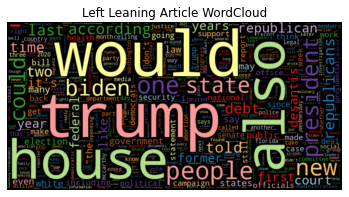

In [19]:
wordcloud(Left_Lean_counts['freq'], title="Left Leaning Article WordCloud", max_words=500)

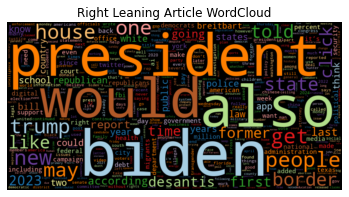

In [20]:
wordcloud(Right_Lean_counts['freq'], title="Right Leaning Article WordCloud", max_words=500)

### Topic Modeling Right vs Left:

In [39]:
Left_tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
Left_topic_modeling_input = Left_tfidf_topic.fit_transform(Left_lean_articles_df['cleaner_text'])

In [40]:
Right_tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
Right_topic_modeling_input = Right_tfidf_topic.fit_transform(Right_lean_articles_df['cleaner_text'])

In [49]:
nmf_text_model_newsL = NMF(n_components=3, random_state=314)
Left_text_matrix = nmf_text_model_newsL.fit_transform(Left_topic_modeling_input)
HLeft_text_matrix = nmf_text_model_newsL.components_

In [50]:
nmf_text_model_newsR = NMF(n_components=3, random_state=314)
Right_text_matrix = nmf_text_model_newsR.fit_transform(Right_topic_modeling_input)
HRight_text_matrix = nmf_text_model_newsR.components_

Display Topics for Left vs Right:

In [51]:
display_topics(nmf_text_model_newsL, Left_tfidf_topic.get_feature_names_out())


Topic 00
  trump (1.75)
  desantis (1.14)
  president (0.32)
  campaign (0.32)
  former (0.31)

Topic 01
  debt (0.97)
  house (0.63)
  mccarthy (0.61)
  biden (0.60)
  debt ceiling (0.57)

Topic 02
  court (0.21)
  state (0.21)
  police (0.15)
  people (0.15)
  abortion (0.14)


In [52]:
display_topics(nmf_text_model_newsR, Right_tfidf_topic.get_feature_names_out())


Topic 00
  biden (0.22)
  debt (0.17)
  house (0.16)
  ai (0.14)
  bill (0.13)

Topic 01
  border (1.72)
  migrants (1.12)
  title (0.71)
  title 42 (0.65)
  42 (0.64)

Topic 02
  desantis (1.29)
  trump (1.24)
  percent (0.59)
  president (0.41)
  florida (0.39)


Only one missing value:

In [43]:
api_data_complete_df.isna().sum()

source_name             0
author                 37
title                   0
url                     0
publish_date            0
content              3351
article_text            1
tokens                  0
cleaner_text            0
Political_Lean          0
word_count_tokens       0
word_count              0
dtype: int64

In [61]:
api_data_complete_df.head(150)

,source_name,author,title,url,publish_date,content,article_text,tokens,cleaner_text,Political_Lean,word_count_tokens,word_count,word_count_cleaner
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ...",travelers in alabama driving on interstate 65 ...,Left,571,923,923
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ...",a federal prosecutor may be nearing a decision...,Left,645,1089,1089
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa...",a federal appeals court tuesday cleared the wa...,Left,529,869,869
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican...",speaking in orlando in november 2015 republica...,Left,533,956,956
4,The Washington Post,NaN,The revolt of Christian home-schoolers...,https://www.washingtonpost.com/education/inter...,2023-05-30T18:25:37Z,Deep Reads features The Washington Posts best ...,NaN,[],nan,Left,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,The Washington Post,Philip Bump,Evidence grows that Trump hoarded documents — ...,https://www.washingtonpost.com/politics/2023/0...,2023-05-26T15:21:42Z,Comment on this story\r\nComment\r\nWe have re...,We have reached one of those points in reporti...,"[reached, one, points, reporting, donald, trum...",we have reached one of those points in reporti...,Left,582,1006,1006
146,The Washington Post,Meryl Kornfield,Boebert dismisses antisemitism push as effort ...,https://www.washingtonpost.com/politics/2023/0...,2023-05-26T17:04:32Z,Comment on this story\r\nComment\r\nPresident ...,President Biden on Thursday released the count...,"[president, biden, thursday, released, country...",president biden on thursday released the count...,Left,564,919,919
147,The Washington Post,Jennifer Rubin,This is how you fight fascism,https://www.washingtonpost.com/opinions/2023/0...,2023-05-26T11:59:20Z,Comment on this story\r\nComment\r\nIm delight...,You’re reading Jennifer Rubin’s subscriber-onl...,"[you’re, reading, jennifer, rubin’s, subscribe...",you’re reading jennifer rubin’s subscriberonly...,Left,1006,1725,1725
148,The Washington Post,Jacob Bogage,JPMorgan kept Epstein as client for years afte...,https://www.washingtonpost.com/business/2023/0...,2023-05-26T09:05:16Z,Comment on this story\r\nComment\r\nWhen the b...,When the banker learned a court had affirmed J...,"[banker, learned, court, affirmed, jeffrey, ep...",when the banker learned a court had affirmed j...,Left,1049,1766,1766


----------------


## Modeling:

In [44]:
# Obtain total counts of words in the entire corpus:

word_dist=Counter([item for sublist in api_data_complete_df['tokens'] 
                   for item in sublist])

### Prepare data for modeling (Target defined, clean text as X)

In [46]:
# generate the dict data to then be filtered through
# the filtered_words list:

news_data=dict()

    
news_data=[(api_data_complete_df.at[index,'cleaner_text'],
            api_data_complete_df.at[index,'Political_Lean']) for (index,row) in api_data_complete_df.iterrows()]

### Feature Words filtering:

In [47]:
word_cutoff=5
feature_words2=[]
for word, count in word_dist.items() :
    #for convention_data_df['word_dist']
    if count > word_cutoff :
        feature_words2.append(word)
            
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words2)} as features in the model.")

With a word cutoff of 5, we have 22181 as features in the model.


In [155]:
#feature_words2

In [324]:
# remove cnn and fox-news from the key featurewords:

#feature_words2.remove("cnn")
#feature_words2.remove("fox")
#feature_words2.remove("wpost")
#feature_words2.remove("breitbart")


In [48]:
# Filter the data through the feature words set
# determined above:

featuresets=dict()
featuresets = [(conv_features(text,feature_words2), 
                lean) for (text, lean) in news_data]

In [156]:
#featuresets

In [ ]:
#api_record_df['full_text']

### Rough Naive-Bayes Classifier setup and run-through:

In [49]:
random.seed(42)
random.shuffle(featuresets)
test_size = 20


In [50]:
test_set=dict()
train_set=dict()
test_set, train_set = featuresets[:test_size], featuresets[test_size:]

In [51]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.2


In [52]:
# Confusion Matrix:

predicted_labels = [classifier.classify(features) for features, 
                    label in test_set]
gold_labels = [label for features, label in test_set]

cm = ConfusionMatrix(gold_labels, predicted_labels)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

      |      R        |
      |      i      L |
      |      g      e |
      |      h      f |
      |      t      t |
------+---------------+
Right |     <.> 80.0% |
 Left |      . <20.0%>|
------+---------------+
(row = reference; col = test)



### Linear SVC (SVM) implementation:

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(api_data_complete_df2['cleaner_text'],
                                                    api_data_complete_df2['Political_Lean'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=api_data_complete_df2['Political_Lean'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  3221
Size of Test Data  806


In [67]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [68]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [69]:
X_test_tf = tfidf.transform(X_test)

In [70]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.9578163771712159


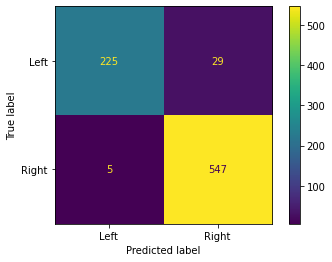

In [71]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

----

## Initiate MySQL connection

In [14]:
'''Set local environment variables to hide user name & password citation:
https://www.geeksforgeeks.org/how-to-hide-sensitive-credentials-using-python/'''

user_name = "sqluser"
user_pass = "password"

#user_name = os.environ['MySQLUSRAC']
#user_pass = os.environ['MySQLPWDAC']

# Instantiate connection
db_conn = mysql.connect(host='localhost',
                        port=int(3306),
                        user=user_name,
                        passwd=user_pass,
                        db='509_final_proj')

# Create a cursor object
cursor = db_conn.cursor()

In [15]:
tbl_names = pd.read_sql('SHOW TABLES', db_conn)

display(tbl_names)
print(type(tbl_names))

c:\Users\Susy\anaconda3\envs\humans\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Tables_in_509_final_proj


<class 'pandas.core.frame.DataFrame'>


### Establish logging policy

In [20]:
'''Logging citations (see additional code in following code blocks:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
https://docs.python.org/3/howto/logging.html#logging-basic-example;
https://docs.python.org/3/howto/logging.html#logging-to-a-file;
https://docs.python.org/3/howto/logging-cookbook.html#using-a-rotating-log-file-handler;
https://docs.python.org/3/howto/logging-cookbook.html#using-a-timed-rotating-file-handler'''

# Set up logging
logging.basicConfig(level=logging.INFO,
                    filename='pymysql.log',
                    filemode='a',
                    format='>>>>>>>>>>>>>><<<<<<<<<<<<<<\n%(asctime)s - %(levelname)s - %(message)s')

### Update individual tables

#### Update `news_articles` table from API

In [21]:
nat_tbl_name = 'nar_temp'
nwa_tbl_name = 'news_articles'

In [22]:
'''Using cursor and loading into temp file:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
https://pynative.com/python-mysql-insert-data-into-database-table/'''

# Execute query and measure execution time
start_time = time.time()

# Wipe temp table
try:
    nat_dlt_tble_stmnt = f"""DELETE FROM {nat_tbl_name}"""
    cursor.execute(nat_dlt_tble_stmnt)
    logging.info(f'Successfully executed query:\n{nat_dlt_tble_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_dlt_tble_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Load data from CSV file into a temporary table
try:
    nat_csv_load_stmnt = f"""
    INSERT INTO {nat_tbl_name}
    (
    source_name,
    author,
    title,
    url,
    publish_date,
    content
    )
    VALUES (%s, %s, %s, %s, %s, %s)
    """

    # Execute the query with multiple values
    cursor.executemany(nat_csv_load_stmnt, api_record_lst02)
    #cursor.execute(nat_csv_load_stmnt)
    logging.info(f'Successfully executed query:\n{nat_csv_load_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_csv_load_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Insert new records into main table
try:
    nwa_load_stmnt = f"""
    INSERT INTO {nwa_tbl_name}
    (
    source_name,
    author,
    title,
    url,
    publish_date,
    content
    )
    SELECT
        tp.source_name,
        tp.author,
        tp.title,
        tp.url,
        tp.publish_date,
        tp.content
    FROM {nat_tbl_name} AS tp
    LEFT JOIN {nwa_tbl_name} AS mn
        ON tp.title = mn.title
            AND CAST(LEFT(tp.publish_date, 10) AS DATE) = CAST(LEFT(mn.publish_date, 10) AS DATE)
            AND tp.author = mn.author
    """
    cursor.execute(nwa_load_stmnt)
    logging.info(f'Successfully executed query:\n{nwa_load_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nwa_load_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Wipe temp table
try:
    cursor.execute(nat_dlt_tble_stmnt)
    logging.info(f'Successfully executed query:\n{nat_dlt_tble_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_dlt_tble_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

### Commit changes and close cursor and connection instances

In [23]:
# Commit the changes to the database
db_conn.commit()

# Close the cursor and database connection
cursor.close()
db_conn.close()